# _**Convergence for the Poisson stationary flow**_

### _Libraries_

In [1]:
from mpi4py import MPI # Message Passing Interface.
from petsc4py import PETSc # Library for solving PDE's assosiated linear problems
# Is an standar for different libraries to function properly and with high performance
import dolfinx # FeniCSx Interface
import numpy as np # Numpy, the classic
from petsc4py.PETSc import ScalarType

import ufl
from basix.ufl import element, mixed_element # Elements for the FEM
from dolfinx import default_real_type, fem, la # FEM library with the functions required for solving through FEM (for real values)
from dolfinx.fem import (
    Constant,
    Function,
    dirichletbc,
    extract_function_spaces,
    form,
    functionspace,
    create_interpolation_data,
    locate_dofs_topological,
    assemble_scalar,
) # Functions for defining variational problems and defining mathematical functions and constants
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, LinearProblem # Functions for creating the matrix problems
from dolfinx.io import XDMFFile
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary # Mesh creating functions
from ufl import div, dx, grad, inner, TrialFunction, TestFunction # operand functions

Forma variacional
$$ \int_\Omega \nabla U \cdot \nabla V d\Omega = \int_\Omega C \cdot V d\Omega \ ; \ \forall V \in \hat{T} $$

### _Malla y solución_

In [2]:
# Square mesh creating function
def square_mesh(n):
    """
    Creates a square mesh given n, the number of divisions in each directions
    """
    return create_rectangle(MPI.COMM_WORLD, [np.array([0,0]), np.array([1,1])], [n,n], CellType.triangle)

In [3]:
# Circle mesh creating function
def circle_mesh(n):
    """
    Creates a circle mesh given n. Uses a resolution given by 1/n for a gmsh created mesh
    """
    h = 1/n
    k = list(str(h))
    k.pop(1)
    num = "".join(k)
    msh, cell_tags, facet_tags = dolfinx.io.gmshio.read_from_msh("Meshes/Circle_mesh" + num + ".msh", MPI.COMM_SELF, gdim=2)
    return msh, cell_tags, facet_tags

In [4]:
# no-slip function
def noslip_boundary(x):
    return np.isclose(x[0], 0.0) | np.isclose(x[0], 1.0) | np.isclose(x[1], 0.0) | np.isclose(x[1], 1.0)

In [5]:
# Solution function
def solution(n, domain, c, elem="Lagrange"):
    """
    Calculates the solution for the Poisson equation with no-slip boundary condition in all boundaries
    given a mesh and an optional element for the velocity functionspace.

    Args:
        n: number of divisions of the mesh boundary
        domain: type of domain
            Square or Circle are available
        c: Constant value of the right side of the PDE
        elem: element for the velocity functionspace

    Returns:
        V: functionspace for the velocity
        u: velocity coeficients
    """
    if domain == "square":
        msh = square_mesh(n)
    elif domain == "circle":
        msh, cell_tags, facet_tags = circle_mesh(n)


    # Functionspace
    V = functionspace(msh, (elem, 1))

    # No-slip boundary conditions
    if domain == "square":
        facets = locate_entities_boundary(msh, 1, noslip_boundary)
    elif domain == "circle":
        facets = facet_tags.indices[facet_tags.values == 12]

    noslip = Function(V) # V = 0 

    dofs = locate_dofs_topological(V, 1, facets)
    bc = dirichletbc(noslip, dofs)


    # Variational formulation
    u = TrialFunction(V)
    v = TestFunction(V)

    f = Constant(msh, ScalarType(c))
    a = form(inner(grad(u), grad(v)) *dx) # Bilinear form
    L = form(inner(f, v) * dx) # Linear form


    # Linear problem
    A = assemble_matrix(a, bcs=[bc])
    A.assemble()
    b = assemble_vector(L)
    apply_lifting(b, [a], bcs=[[bc]]) # Adjusts b to keep the equality Ax=b after applying bcs to A

    # Sincronization of the ghost values for parallel computing
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE) 
    bc.set(b) # Apply boundary condition to b


    # PETSc Solver (Krylov Subspace)
    ksp = PETSc.KSP().create(msh.comm) 
    ksp.setOperators(A) # Set matrix for the system
    ksp.setType("cg") # ksp solver ; gmres, cr, chebyshev, ... ; help(ksp.Type)

    pc = ksp.getPC() # Preconditioner
    pc.setType("lu") # LU, ILU, QR, SOR, GALERKIN, ... ;  help(pc.Type)

    pc.setFactorSolverType("superlu_dist") # Solver type to calculate preconditioner/factorization
    u = Function(V)
    ksp.solve(b, u.x.petsc_vec)

    return V, u

### _Cálculo de soluciones_

In [6]:
domain = "square"
if domain == "square":
    total = 6
    sizes = [2**(i+4) for i in range(total)]
elif domain == "circle":
    total = 5
    sizes = [2**(i+1) for i in range(total)]
function_spaces = []
velocities = []
c = 5

for n in sizes:
    print(f"Calulating solution for n = {n}...")
    V, u = solution(n, domain, c)
    function_spaces.append(V)
    velocities.append(u)
    print("Solved!")

Calulating solution for n = 16...
Solved!
Calulating solution for n = 32...
Solved!
Calulating solution for n = 64...
Solved!
Calulating solution for n = 128...
Solved!
Calulating solution for n = 256...
Solved!
Calulating solution for n = 512...
Solved!


## **_Convergence Rate_**

### _Error norm function_

In [7]:
def norm(norm_type: str ,u_ex: dolfinx.fem.function.Function, V_ex: dolfinx.fem.function.FunctionSpace, u_h :dolfinx.fem.function.Function, V_h: dolfinx.fem.function.FunctionSpace, cells_fine: np.ndarray):
    """
    Calculates the error norm between a "exact" solution and a approximated solution to a 
    PDE calculated through the FEM given the solutions and their respective functions spaces
    """
    
    # ----------------------------- mesh interpolation ----------------------------- #
    # Interpolamos la solución aproximada sobre la malla fina
    u_h_coarse_to_fine = Function(V_ex)  # Nueva función en la malla fina
    interpolation_data = create_interpolation_data(V_ex, V_h, cells_fine)  # Datos para interpolar entre espacios no coincidentes
    u_h_coarse_to_fine.interpolate_nonmatching(u_h, cells_fine, interpolation_data=interpolation_data)  # Interpolación
    u_h_coarse_to_fine.x.scatter_forward()  # Sincroniza datos entre procesos
    # ------------------------------------------------------------------------------ #


    # ------------------------------ Error ------------------------------ #
    e = u_ex - u_h_coarse_to_fine
            
    if norm_type == "L2":
        error = form((inner(e,e))* dx) # Formamos la integral
        error_local = assemble_scalar(error) # calculamos la integral
        return np.sqrt(V_ex.mesh.comm.allreduce(error_local, op=MPI.SUM)) # Sumamos los errores en cada punto

    elif norm_type == "H1":
        error = form((inner(e,e) + inner(grad(e),grad(e)))* dx) # Formamos la integral
        error_local = assemble_scalar(error) # calculamos la integral
        return np.sqrt(V_ex.mesh.comm.allreduce(error_local, op=MPI.SUM)) # Sumamos los errores en cada punto
    # ------------------------------------------------------------------- #

Exact solution cells information

In [8]:
u_ex = velocities[-1]
V_ex = function_spaces[-1]

cells_fine_map = V_ex.mesh.topology.index_map(V_ex.mesh.topology.dim)
num_cells_on_proc_fine = cells_fine_map.size_local + cells_fine_map.num_ghosts
cells_fine = np.arange(num_cells_on_proc_fine, dtype=np.int32)

### _L^2_

In [9]:
norm_type = "L2"
total = len(sizes) - 1
h = np.array([1/n for n in sizes][:total])
error_L2 = np.array([0. for i in range(total)])

for i in range(total):
    u_h = velocities[i]
    V_h = function_spaces[i]
    error_L2[i] = norm(norm_type, u_ex, V_ex, u_h, V_h, cells_fine)

In [10]:
x_ref = 1/h[:total]
y0 = error_L2[-2]
x0 = x_ref[-2]
asintota = y0 * (x_ref/x0)**(-2) 

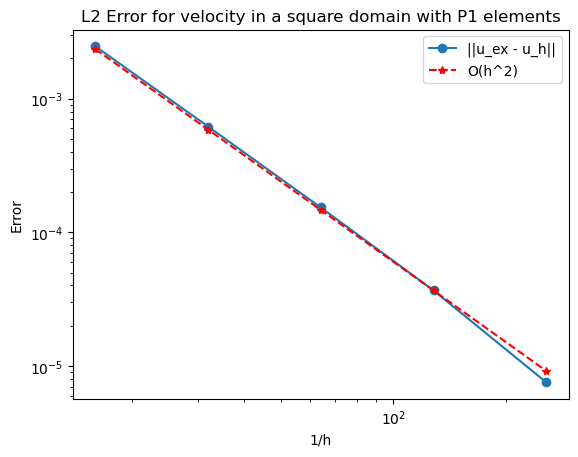

In [ ]:
import matplotlib.pyplot as plt

plt.loglog(1/h[:total], error_L2, "o-", label= "||u_ex - u_h||")
plt.loglog(x_ref, asintota, "r*--", label="O(h^2)")
plt.legend(loc="upper right")
plt.title(f"{norm_type} Error for u in a {domain} domain with P1 elements")
plt.xlabel("1/h")
plt.ylabel("Error")
plt.show()

In [12]:
Slope, intercept = np.polyfit(np.log(1/h[total-2:total]), np.log(error_L2[total-2:]), 1)
print(f"Tasa de convergencia en la norma {norm_type} = {-Slope}")

Tasa de convergencia en la norma L2 = 2.2842150490788655


### _H1_

In [13]:
norm_type = "H1"
total = len(sizes) - 1
h = np.array([1/n for n in sizes][:total])
error_H1 = np.array([0. for i in range(total)])

for i in range(total):
    u_h = velocities[i]
    V_h = function_spaces[i]
    error_H1[i] = norm(norm_type, u_ex, V_ex, u_h, V_h, cells_fine)

In [14]:
x_ref = 1/h[:total]
y0 = error_H1[-2]
x0 = x_ref[-2]
asintota = y0 * (x_ref/x0)**(-1) 

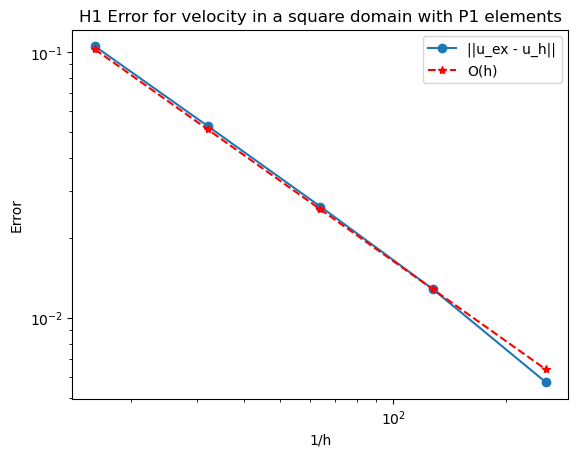

In [ ]:
import matplotlib.pyplot as plt

plt.loglog(1/h[:total], error_H1, "o-", label= "||u_ex - u_h||")
plt.loglog(x_ref, asintota, "r*--", label="O(h)")
plt.legend(loc="upper right")
plt.title(f"{norm_type} Error for u in a {domain} domain with P1 elements")
plt.xlabel("1/h")
plt.ylabel("Error")
plt.show()

In [ ]:
Slope, intercept = np.polyfit(np.log(1/h[total-2:total]), np.log(error_H1[total-2:]), 1)
print(f"Tasa de convergencia en la norma {norm_type} = {-Slope}")

Tasa de convergencia en la norma H1 = 1.1608351717660603
